# Signal Comparison Minimal v3: Multi-Instrument Analysis with Envelope Visualization

Compare Fourier series model with multiple instruments and notes, including amplitude envelope analysis.

## Mathematical Model Being Tested

The model being tested is a **dual Fourier series resonator model** that represents the transformation of an electric sasando signal to replicate the acoustic characteristics of a traditional sasando.

### Base Model (Steady-State):

$$
f_{\text{steady}}(t) = \sum_{n=0}^{\infty} A_n \cos\left(n\omega_0 t + \phi_n\right) + \sum_{n=0}^{\infty} \alpha_n A_n \cos\left(n\omega_0 t + \phi_n + \theta\right)
$$

### Model with Exponential Decay:

To capture the natural decay of plucked strings, we multiply the base model by an exponential envelope:

$$
f_{\text{decay}}(t) = E(t) \cdot f_{\text{steady}}(t) = E(t) \cdot \left[ \sum_{n=0}^{\infty} A_n \cos\left(n\omega_0 t + \phi_n\right) + \sum_{n=0}^{\infty} \alpha_n A_n \cos\left(n\omega_0 t + \phi_n + \theta\right) \right]
$$

Where the envelope function $E(t)$ is:

**Version 1: Extracted Decay (from signal)**
$$
E_{\text{extracted}}(t) = A_0 \cdot e^{-t/\tau}
$$
- $A_0$: Initial amplitude (extracted from signal's maximum envelope)
- $\tau$: Decay time constant (fitted from signal's envelope)

**Version 2: Manually Defined Decay**
$$
E_{\text{manual}}(t) = A_0^{\text{manual}} \cdot e^{-t/\tau^{\text{manual}}}
$$
- $A_0^{\text{manual}}$: User-defined initial amplitude
- $\tau^{\text{manual}}$: User-defined decay time constant

### Model Components:

**First Series:** $\sum_{n=0}^{\infty} A_n \cos(n\omega_0 t + \phi_n)$
- Represents the original signal decomposed into harmonics
- $A_n$: Amplitude coefficient for the $n$-th harmonic (extracted from input signal)
- $\phi_n$: Phase coefficient for the $n$-th harmonic (extracted from input signal)
- $\omega_0 = 2\pi f_0$: Fundamental frequency in rad/s
- $n$: Harmonic index (0 = DC, 1 = fundamental, 2, 3, ... = harmonics)

**Second Series:** $\sum_{n=0}^{\infty} \alpha_n A_n \cos(n\omega_0 t + \phi_n + \theta)$
- Represents the resonator's contribution to the sound
- $\alpha_n$: Frequency-dependent amplitude scaling factor (models resonator response)
  - Larger values (0.8) for frequencies in sasando range (98-1047 Hz)
  - Smaller values (0.2) for frequencies outside this range
- $\theta$: Phase shift introduced by the resonator (constant, typically $\pi/4$ rad)

### What This Model Tests:

1. **Feature Extraction:** Can we extract $A_n$ and $\phi_n$ from real audio signals?
2. **Harmonic Reconstruction:** Can we reconstruct signals using only harmonic components?
3. **Resonator Modeling:** Does the dual-series approach capture resonator effects?
4. **Frequency Matching:** How well do the model's frequencies match the original?
5. **Amplitude Matching:** How well do the model's amplitudes match the original?
6. **Envelope Analysis:** Does the model capture the decay characteristics of plucked strings?
7. **Decay Comparison:** How do extracted decay parameters compare to manually defined ones?

### Current Implementation:

- **Auto-detection:** Automatically detects significant harmonics up to 70 harmonics or within sasando range (98-1047 Hz)
- **Feature-based:** Uses features extracted directly from each signal (not generic functions)
- **Resonator effect:** Includes both series when `INCLUDE_RESONATOR=True`
- **Envelope analysis:** Extracts and visualizes amplitude envelopes to study decay patterns
- **Decay models:** Generates both extracted-decay and manually-defined-decay versions for comparison

## Analysis Scope

- **3 Instruments:** Acoustic Guitar, Classical Guitar, Electric Guitar
- **3 Notes per instrument:** C, D, E
- **Extract features** and match Fourier model to each
- **Amplitude envelope visualization** to analyze decay patterns


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import hilbert
from pathlib import Path
import os

try:
    import librosa
except ImportError:
    print("Install librosa: pip install librosa")

plt.rcParams['figure.figsize'] = (16, 8)


In [12]:
def load_audio(file_path):
    """Load audio file (.m4a, .wav, .mp3, .csv)"""
    file_path = Path(file_path)
    
    # Try different path resolutions
    if file_path.is_absolute():
        resolved_path = file_path
    else:
        if file_path.exists():
            resolved_path = file_path
        elif (Path('ryan_files') / file_path).exists():
            resolved_path = Path('ryan_files') / file_path
        elif Path.cwd().name == 'ryan_files' and (Path('..') / file_path).exists():
            resolved_path = Path('..') / file_path
        else:
            alt_path = Path('ryan_files') / file_path
            if alt_path.exists():
                resolved_path = alt_path
            else:
                resolved_path = file_path
    
    resolved_path = resolved_path.resolve()
    
    if not resolved_path.exists():
        raise FileNotFoundError(f"Audio file not found: {file_path}\nTried: {resolved_path}")
    
    if resolved_path.suffix.lower() == '.csv':
        data = np.genfromtxt(resolved_path, delimiter=',', skip_header=1)
        time = data[:, 0] / 1000.0 if np.max(data[:, 0]) > 1000 else data[:, 0]
        amplitude = data[:, 1]
        if np.max(np.abs(amplitude)) > 0:
            amplitude = amplitude / np.max(np.abs(amplitude))
        sample_rate = 1.0 / (time[1] - time[0])
    else:
        amplitude, sample_rate = librosa.load(str(resolved_path), sr=None, mono=True)
        time = np.arange(len(amplitude)) / sample_rate
    
    return time, amplitude, sample_rate


In [13]:
def extract_envelope(signal, sample_rate, method='hilbert', smoothing_window=100):
    """
    Extract amplitude envelope from signal.
    
    Parameters:
    -----------
    signal : array
        Audio signal
    sample_rate : float
        Sampling rate
    method : str
        'hilbert' - Uses Hilbert transform (more accurate)
        'abs' - Simple absolute value
    smoothing_window : int
        Window size for smoothing (in samples)
    
    Returns:
    --------
    envelope : array
        Amplitude envelope
    """
    if method == 'hilbert':
        # Use Hilbert transform for accurate envelope
        analytic_signal = hilbert(signal)
        envelope = np.abs(analytic_signal)
    else:
        # Simple absolute value
        envelope = np.abs(signal)
    
    # Smooth the envelope
    if smoothing_window > 1:
        # Use moving average
        kernel = np.ones(smoothing_window) / smoothing_window
        envelope = np.convolve(envelope, kernel, mode='same')
    
    return envelope


In [14]:
def process_fourier_series(signal, sample_rate, time,
                           omega_0=None, num_harmonics=20,
                           A_n=None, phi_n=None, alpha_n=None, theta=0.0,
                           include_resonator=True):
    """
    Process signal using Fourier series model:
    f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)
    
    If include_resonator=False, only reconstructs the first series (no resonator effect).
    This is useful when extracting features from a signal that already has resonator effects.
    """
    fft_signal = rfft(signal)
    freqs = rfftfreq(len(signal), 1/sample_rate)
    magnitude = np.abs(fft_signal)
    phase = np.angle(fft_signal)
    
    if omega_0 is None:
        mask = (freqs >= 20) & (freqs <= 2000)
        if np.any(mask):
            peak_idx = np.argmax(magnitude[mask])
            omega_0 = 2 * np.pi * freqs[mask][peak_idx]
        else:
            omega_0 = 2 * np.pi * 261.63
    
    f0_hz = omega_0 / (2 * np.pi)
    
    def get_coeff(coeff, n, default):
        if coeff is None:
            return default(n) if callable(default) else default
        elif isinstance(coeff, (list, np.ndarray)):
            if n < len(coeff):
                return coeff[n]
            return 0.0
        elif callable(coeff):
            return coeff(n)
        else:
            return coeff
    
    processed = np.zeros_like(signal)
    use_extracted = (isinstance(A_n, (list, np.ndarray)) and 
                     isinstance(phi_n, (list, np.ndarray)) and
                     len(A_n) >= num_harmonics and len(phi_n) >= num_harmonics)
    
    for n in range(num_harmonics):
        if use_extracted:
            A = A_n[n]
            phi = phi_n[n]
        else:
            target_freq = n * f0_hz
            if target_freq <= freqs[-1]:
                idx = np.argmin(np.abs(freqs - target_freq))
                A_input = magnitude[idx] / len(signal)
                phi_input = phase[idx]
                A_coeff = get_coeff(A_n, n, lambda n: 1.0)
                phi_coeff = get_coeff(phi_n, n, lambda n: 0.0)
                A = A_input * A_coeff
                phi = phi_input + phi_coeff
            else:
                A = 0.0
                phi = 0.0
        
        # First series: A_n cos(nω₀t + φ_n)
        processed += A * np.cos(n * omega_0 * time + phi)
        
        # Second series: α_n A_n cos(nω₀t + φ_n + θ) - only if include_resonator=True
        if include_resonator:
            alpha = get_coeff(alpha_n, n, lambda n: 0.5)
            processed += alpha * A * np.cos(n * omega_0 * time + phi + theta)
    
    # Don't normalize here - let the caller handle normalization if needed
    # The model should reconstruct the signal at its natural amplitude
    # Normalization was causing issues with amplitude matching
    return processed


## Configuration


In [15]:
# Configuration
NUM_HARMONICS = None  # Set to None to auto-detect from signal, or specify a number (e.g., 25)
THETA = np.pi / 4  # Phase shift (radians)
INCLUDE_RESONATOR = True  # Set to False to reconstruct only the base signal (first series)
                           # Set to True to add resonator effect (second series)

# Auto-detection parameters (used when NUM_HARMONICS is None)
HARMONIC_THRESHOLD = 0.001  # Minimum normalized magnitude to count as significant harmonic (lowered to capture more harmonics)
MAX_HARMONICS = 200  # Maximum number of harmonics to detect (increased to capture more)
SASANDO_FREQ_MIN = 98  # Minimum frequency for sasando range (Hz)
SASANDO_FREQ_MAX = 1047  # Maximum frequency for sasando range (Hz)

# Envelope extraction parameters
ENVELOPE_METHOD = 'hilbert'  # 'hilbert' or 'abs'
ENVELOPE_SMOOTHING = 100  # Smoothing window size (samples)

# Decay model parameters
APPLY_DECAY = True  # Set to True to apply exponential decay envelope
USE_EXTRACTED_DECAY = True  # If True, use decay parameters extracted from signal
                            # If False, use manually defined parameters below

# Visualization flags
SHOW_ENVELOPE_ANALYSIS = False  # Set to False to hide envelope analysis plots
SHOW_MANUAL_DECAY = False  # Set to True to show manual decay version in plots (when APPLY_DECAY=True)

# Manually defined decay parameters (used when USE_EXTRACTED_DECAY=False)
MANUAL_DECAY_TAU = 1.0  # Decay time constant (seconds) - smaller = faster decay
MANUAL_DECAY_A0 = 1.0   # Initial amplitude

# Define instruments and notes to process
INSTRUMENTS = ['acoustic guitar', 'classical guitar', 'electric guitar']
NOTES = ['C', 'D', 'E']  # 3 notes per instrument
SAMPLE_NUM = 1  # Use _1.m4a files (can change to 2, 3, etc.)

# Define alpha_n function (resonator response)
def alpha_n_func(n, estimated_f0):
    """Frequency-dependent scaling based on sasando range (98-1047 Hz)"""
    freq_hz = n * estimated_f0
    return 0.8 if 98 <= freq_hz <= 1047 else 0.2

print("Configuration:")
print(f"  Instruments: {INSTRUMENTS}")
print(f"  Notes: {NOTES}")
if NUM_HARMONICS is None:
    print(f"  Harmonics: Auto-detect (threshold={HARMONIC_THRESHOLD}, max={MAX_HARMONICS})")
    print(f"  Sasando frequency range: {SASANDO_FREQ_MIN}-{SASANDO_FREQ_MAX} Hz")
else:
    print(f"  Harmonics: {NUM_HARMONICS} (fixed)")
print(f"  Phase shift θ: {THETA:.4f} rad ({np.degrees(THETA):.1f}°)")
print(f"  Include resonator effect: {INCLUDE_RESONATOR}")
print(f"  Envelope method: {ENVELOPE_METHOD} (smoothing={ENVELOPE_SMOOTHING} samples)")
print(f"  Apply decay envelope: {APPLY_DECAY}")
print(f"  Show manual decay in plots: {SHOW_MANUAL_DECAY}")
if APPLY_DECAY:
    if USE_EXTRACTED_DECAY:
        print("  → Using decay parameters extracted from signal")
    else:
        print(f"  → Using manually defined decay: τ={MANUAL_DECAY_TAU}s, A₀={MANUAL_DECAY_A0}")
if not INCLUDE_RESONATOR:
    print("  → Reconstructing only base signal (first series) to match original")
else:
    print("  → Adding resonator effect (both series)")


Configuration:
  Instruments: ['acoustic guitar', 'classical guitar', 'electric guitar']
  Notes: ['C', 'D', 'E']
  Harmonics: Auto-detect (threshold=0.001, max=200)
  Sasando frequency range: 98-1047 Hz
  Phase shift θ: 0.7854 rad (45.0°)
  Include resonator effect: True
  Envelope method: hilbert (smoothing=100 samples)
  Apply decay envelope: True
  Show manual decay in plots: False
  → Using decay parameters extracted from signal
  → Adding resonator effect (both series)


## Process All Instruments and Notes


In [16]:
# Store results for all combinations
results = {}

for instrument in INSTRUMENTS:
    results[instrument] = {}
    
    for note in NOTES:
        # Construct file path (files are named like C_acoustic_1.m4a, not C_acoustic_guitar_1.m4a)
        instrument_short = instrument.split()[0]  # Get first word: "acoustic", "classical", "electric"
        filename = f"{note}_{instrument_short}_{SAMPLE_NUM}.m4a"
        file_path = f"Data/{instrument}/{filename}"
        
        print(f"\n{'='*80}")
        print(f"Processing: {instrument} - Note {note}")
        print(f"File: {file_path}")
        print('='*80)
        
        try:
            # Load audio
            time, amplitude_original, sample_rate = load_audio(file_path)
            print(f"  Loaded: {sample_rate:.1f} Hz, {time[-1]:.2f}s duration")
            
            # Extract envelope from original signal
            envelope_original = extract_envelope(
                amplitude_original, sample_rate, 
                method=ENVELOPE_METHOD, 
                smoothing_window=ENVELOPE_SMOOTHING
            )
            
            # Extract features
            fft_original = rfft(amplitude_original)
            freqs_original = rfftfreq(len(amplitude_original), 1/sample_rate)
            magnitude_original = np.abs(fft_original)
            phase_original = np.angle(fft_original)
            
            # Estimate fundamental
            mask = (freqs_original >= 20) & (freqs_original <= 2000)
            if np.any(mask):
                peak_idx = np.argmax(magnitude_original[mask])
                estimated_f0 = freqs_original[mask][peak_idx]
                omega_0 = 2 * np.pi * estimated_f0
            else:
                estimated_f0 = 261.63
                omega_0 = 2 * np.pi * estimated_f0
            
            print(f"  Estimated fundamental: {estimated_f0:.2f} Hz")
            
            # Auto-detect number of harmonics if not specified
            if NUM_HARMONICS is None:
                # Strategy: Collect all significant harmonics up to:
                # 1. MAX_HARMONICS limit, OR
                # 2. Until we exceed SASANDO_FREQ_MAX, OR
                # 3. Until we exceed available FFT range
                max_magnitude = np.max(magnitude_original)
                significant_harmonics = []
                
                for n in range(1, MAX_HARMONICS + 1):  # Start from n=1 (skip DC)
                    target_freq = n * estimated_f0
                    
                    # Stop if frequency exceeds available FFT range
                    if target_freq > freqs_original[-1]:
                        break
                    
                    # Check if this harmonic is significant
                    idx = np.argmin(np.abs(freqs_original - target_freq))
                    normalized_mag = magnitude_original[idx] / max_magnitude if max_magnitude > 0 else 0
                    
                    if normalized_mag >= HARMONIC_THRESHOLD:
                        significant_harmonics.append(n)
                    # Don't break on weak harmonics - continue to find all significant ones
                    # Only stop if we've checked enough or hit frequency limits
                
                # Include DC component (n=0) and all detected harmonics
                num_harmonics_to_use = len(significant_harmonics) + 1  # +1 for DC
                max_detected = max(significant_harmonics) if significant_harmonics else 0
                max_freq = max_detected * estimated_f0 if max_detected > 0 else 0
                print(f"  Auto-detected {num_harmonics_to_use} harmonics (n=0 to n={max_detected})")
                print(f"  Frequency range: 0 to {max_freq:.1f} Hz (sasando range: {SASANDO_FREQ_MIN}-{SASANDO_FREQ_MAX} Hz)")
                if max_freq > SASANDO_FREQ_MAX:
                    print(f"  Note: Detected harmonics extend beyond sasando range (up to {max_freq:.1f} Hz)")
            else:
                num_harmonics_to_use = NUM_HARMONICS
            
            # Create alpha_n function with this f0 (needed for A_n extraction)
            def alpha_n_with_f0(n):
                return alpha_n_func(n, estimated_f0)
            
            # Extract A_n and φ_n
            # IMPORTANT: Extract A_n such that amplitude_1 + amplitude_2 = original
            # Since original = Σ A_n(1 + α_n)cos(...), we need:
            # A_n = M_n / (1 + α_n) where M_n is the magnitude from FFT
            A_n_extracted = []
            phi_n_extracted = []
            
            for n in range(num_harmonics_to_use):
                target_freq = n * estimated_f0
                if target_freq <= freqs_original[-1]:
                    idx = np.argmin(np.abs(freqs_original - target_freq))
                    
                    # Get magnitude from FFT
                    if n == 0:
                        M_n = magnitude_original[idx] / len(amplitude_original)
                    else:
                        M_n = 2 * magnitude_original[idx] / len(amplitude_original)
                    
                    # Get α_n for this harmonic
                    alpha_n_value = alpha_n_with_f0(n)
                    
                    # Extract A_n accounting for resonator effect
                    # When we add: A_n cos(ωt + φ) + α_n A_n cos(ωt + φ + θ)
                    # The magnitude is: |A_n| × sqrt(1 + 2α_n cos(θ) + α_n²)
                    # So if M_n is the magnitude from FFT, we need:
                    # A_n = M_n / sqrt(1 + 2α_n cos(θ) + α_n²)
                    if INCLUDE_RESONATOR:
                        # Account for resonator contribution with phase shift
                        # Magnitude factor accounts for phase relationship
                        magnitude_factor = np.sqrt(1 + 2 * alpha_n_value * np.cos(THETA) + alpha_n_value**2)
                        A_n = M_n / magnitude_factor if magnitude_factor > 0 else M_n
                    else:
                        # No resonator, so A_n = M_n
                        A_n = M_n
                    
                    phi_n = phase_original[idx]
                    A_n_extracted.append(A_n)
                    phi_n_extracted.append(phi_n)
                else:
                    A_n_extracted.append(0.0)
                    phi_n_extracted.append(0.0)
            
            # Process with Fourier model
            A_n_array = np.array(A_n_extracted)
            phi_n_array = np.array(phi_n_extracted)
            
            amplitude_fourier = process_fourier_series(
                amplitude_original, sample_rate, time,
                omega_0=omega_0,
                num_harmonics=num_harmonics_to_use,
                A_n=A_n_array,
                phi_n=phi_n_array,
                alpha_n=alpha_n_with_f0,
                theta=THETA,
                include_resonator=INCLUDE_RESONATOR
            )
            
            # Analyze decay (fit exponential to envelope) - DO THIS FIRST before using tau
            # Get actual peak amplitude from original signal (for proper scaling)
            peak_amplitude_original = np.max(np.abs(amplitude_original))
            peak_envelope_original = np.max(envelope_original)
            
            # Use first 80% of signal to avoid noise floor
            decay_window = int(0.8 * len(envelope_original))
            if decay_window > 100:
                t_decay = time[:decay_window]
                env_decay = envelope_original[:decay_window]
                
                # Fit exponential: A * exp(-t/τ)
                # Use log-linear fit: log(env) = log(A) - t/τ
                mask_positive = env_decay > 0
                if np.sum(mask_positive) > 10:
                    log_env = np.log(env_decay[mask_positive])
                    t_fit = t_decay[mask_positive]
                    
                    # Linear fit: log(env) = a + b*t
                    coeffs = np.polyfit(t_fit, log_env, 1)
                    tau = -1.0 / coeffs[0] if coeffs[0] < 0 else np.inf
                    # Use actual peak of envelope as A0, not the fitted intercept
                    # This ensures the decay envelope starts at the correct amplitude
                    A0_fit = peak_envelope_original
                else:
                    tau = np.inf
                    A0_fit = peak_envelope_original
            else:
                tau = np.inf
                A0_fit = peak_envelope_original
            
            # Apply exponential decay envelope if enabled
            if APPLY_DECAY:
                if USE_EXTRACTED_DECAY:
                    # Use extracted decay parameters
                    decay_tau = tau
                    # Scale A0 to match the peak of the Fourier model (before decay)
                    # This ensures the decay envelope starts at the right amplitude
                    peak_fourier_steady = np.max(np.abs(amplitude_fourier))
                    if peak_fourier_steady > 0:
                        # Scale decay envelope so initial amplitude matches Fourier model peak
                        decay_A0 = peak_fourier_steady
                    else:
                        decay_A0 = A0_fit
                else:
                    # Use manually defined decay parameters
                    decay_tau = MANUAL_DECAY_TAU
                    peak_fourier_steady = np.max(np.abs(amplitude_fourier))
                    if peak_fourier_steady > 0:
                        decay_A0 = peak_fourier_steady * MANUAL_DECAY_A0
                    else:
                        decay_A0 = MANUAL_DECAY_A0
                
                # Create exponential envelope
                if decay_tau < np.inf and decay_tau > 0:
                    envelope_decay = decay_A0 * np.exp(-time / decay_tau)
                else:
                    # If no valid decay, use constant envelope
                    envelope_decay = np.ones_like(time) * decay_A0
                
                # Apply envelope to Fourier model
                amplitude_fourier_decay = amplitude_fourier * envelope_decay
                
                # Scale to match original signal's initial amplitude (at t=0 or near start)
                # Use the first 5% of the signal to estimate initial amplitude
                initial_window = int(0.05 * len(amplitude_original))
                if initial_window > 10:
                    initial_amplitude_original = np.max(np.abs(amplitude_original[:initial_window]))
                    initial_amplitude_fourier = np.max(np.abs(amplitude_fourier_decay[:initial_window]))
                else:
                    initial_amplitude_original = peak_amplitude_original
                    initial_amplitude_fourier = np.max(np.abs(amplitude_fourier_decay))
                
                if initial_amplitude_fourier > 0 and initial_amplitude_original > 0:
                    # Scale so the initial amplitude matches (but preserve the decay shape)
                    scale_factor = initial_amplitude_original / initial_amplitude_fourier
                    amplitude_fourier_decay = amplitude_fourier_decay * scale_factor
            else:
                # No decay applied
                amplitude_fourier_decay = amplitude_fourier.copy()
                decay_tau = np.inf
                decay_A0 = np.max(np.abs(amplitude_fourier))
            
            # Extract envelope from Fourier model (with decay)
            envelope_fourier = extract_envelope(
                amplitude_fourier_decay, sample_rate,
                method=ENVELOPE_METHOD,
                smoothing_window=ENVELOPE_SMOOTHING
            )
            
            # Also create manually defined decay version for comparison
            if APPLY_DECAY and USE_EXTRACTED_DECAY:
                # Create manual decay version using manually defined parameters
                if MANUAL_DECAY_TAU > 0:
                    envelope_manual = MANUAL_DECAY_A0 * np.exp(-time / MANUAL_DECAY_TAU)
                else:
                    envelope_manual = np.ones_like(time) * MANUAL_DECAY_A0
                
                amplitude_fourier_manual_decay = amplitude_fourier * envelope_manual
                envelope_fourier_manual = extract_envelope(
                    amplitude_fourier_manual_decay, sample_rate,
                    method=ENVELOPE_METHOD,
                    smoothing_window=ENVELOPE_SMOOTHING
                )
            else:
                amplitude_fourier_manual_decay = None
                envelope_fourier_manual = None
            
            # Store results
            results[instrument][note] = {
                'time': time,
                'amplitude_original': amplitude_original,
                'amplitude_fourier': amplitude_fourier,  # Steady-state (no decay)
                'amplitude_fourier_decay': amplitude_fourier_decay,  # With decay applied
                'amplitude_fourier_manual_decay': amplitude_fourier_manual_decay,  # Manual decay version
                'envelope_original': envelope_original,
                'envelope_fourier': envelope_fourier,
                'envelope_fourier_manual': envelope_fourier_manual,
                'sample_rate': sample_rate,
                'f0': estimated_f0,
                'omega_0': omega_0,
                'A_n': A_n_extracted,
                'phi_n': phi_n_extracted,
                'decay_tau': tau,  # Extracted decay tau
                'decay_A0': A0_fit,  # Extracted decay A0
                'decay_tau_used': decay_tau,  # Tau actually used (extracted or manual)
                'decay_A0_used': decay_A0,  # A0 actually used
                'file_path': file_path
            }
            
            # Print extracted features
            print(f"\n  Extracted harmonics:")
            num_to_print = min(10, num_harmonics_to_use)  # Print first 10 or all if fewer
            for n in range(num_to_print):
                freq = n * estimated_f0
                print(f"    n={n}: f={freq:.2f} Hz, A_n={A_n_extracted[n]:.6f}, φ_n={phi_n_extracted[n]:.4f} rad")
            if num_harmonics_to_use > num_to_print:
                print(f"    ... ({num_harmonics_to_use - num_to_print} more harmonics)")
            
            # Print envelope analysis
            print(f"\n  Envelope analysis:")
            print(f"    Initial amplitude: {np.max(envelope_original):.6f}")
            print(f"    Final amplitude: {envelope_original[-1]:.6f}")
            print(f"    Decay ratio: {envelope_original[-1]/np.max(envelope_original):.3f}")
            if tau < np.inf:
                print(f"    Decay time constant (τ): {tau:.3f} s")
                print(f"    Half-life: {tau * np.log(2):.3f} s")
            else:
                print(f"    Decay: Very slow or no decay detected")
            
            # Diagnostics
            max_orig = np.max(np.abs(amplitude_original))
            max_fourier = np.max(np.abs(amplitude_fourier))
            rms_orig = np.sqrt(np.mean(amplitude_original**2))
            rms_fourier = np.sqrt(np.mean(amplitude_fourier**2))
            print(f"\n  Amplitude comparison:")
            print(f"    Original - Max: {max_orig:.6f}, RMS: {rms_orig:.6f}")
            print(f"    Fourier - Max: {max_fourier:.6f}, RMS: {rms_fourier:.6f}")
            print(f"    Ratio (Fourier/Original): {max_fourier/max_orig:.2f}")
            
            print(f"  ✓ Successfully processed")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            import traceback
            traceback.print_exc()
            results[instrument][note] = None

print(f"\n\n{'='*80}")
print(f"Processing complete!")
print(f"  Total: {len(INSTRUMENTS)} instruments × {len(NOTES)} notes = {len(INSTRUMENTS) * len(NOTES)} files")
print(f"{'='*80}")



Processing: acoustic guitar - Note C
File: Data/acoustic guitar/C_acoustic_1.m4a
  Loaded: 48000.0 Hz, 7.55s duration
  Estimated fundamental: 262.63 Hz
  Auto-detected 10 harmonics (n=0 to n=15)
  Frequency range: 0 to 3939.4 Hz (sasando range: 98-1047 Hz)
  Note: Detected harmonics extend beyond sasando range (up to 3939.4 Hz)


/var/folders/2h/t411d17d6jj2cw0g5vgr_jn80000gn/T/ipykernel_63848/2955513416.py:35: UserWarning: PySoundFile failed. Trying audioread instead.
  amplitude, sample_rate = librosa.load(str(resolved_path), sr=None, mono=True)



  Extracted harmonics:
    n=0: f=0.00 Hz, A_n=0.000001, φ_n=0.0000 rad
    n=1: f=262.63 Hz, A_n=0.001913, φ_n=-2.2238 rad
    n=2: f=525.25 Hz, A_n=0.000196, φ_n=-2.3859 rad
    n=3: f=787.88 Hz, A_n=0.000101, φ_n=-0.3593 rad
    n=4: f=1050.50 Hz, A_n=0.000008, φ_n=2.9305 rad
    n=5: f=1313.13 Hz, A_n=0.000008, φ_n=0.8772 rad
    n=6: f=1575.75 Hz, A_n=0.000001, φ_n=-2.6762 rad
    n=7: f=1838.38 Hz, A_n=0.000005, φ_n=-2.8843 rad
    n=8: f=2101.01 Hz, A_n=0.000003, φ_n=-1.1842 rad
    n=9: f=2363.63 Hz, A_n=0.000001, φ_n=-1.7752 rad

  Envelope analysis:
    Initial amplitude: 0.073899
    Final amplitude: 0.002244
    Decay ratio: 0.030
    Decay: Very slow or no decay detected

  Amplitude comparison:
    Original - Max: 0.095612, RMS: 0.007780
    Fourier - Max: 0.003466, RMS: 0.002267
    Ratio (Fourier/Original): 0.04
  ✓ Successfully processed

Processing: acoustic guitar - Note D
File: Data/acoustic guitar/D_acoustic_1.m4a
  Loaded: 48000.0 Hz, 7.42s duration
  Estimated f

## Visualize Amplitude Envelopes

*Envelope analysis is currently hidden. Set `SHOW_ENVELOPE_ANALYSIS = True` to enable.*


In [17]:
# Create envelope visualization for all instruments and notes
if SHOW_ENVELOPE_ANALYSIS:
    for instrument in INSTRUMENTS:
        fig, axes = plt.subplots(len(NOTES), 2, figsize=(16, 4 * len(NOTES)))
        fig.suptitle(f'{instrument.title()}: Amplitude Envelope Analysis', fontsize=16, fontweight='bold')
        
        for note_idx, note in enumerate(NOTES):
            if results[instrument][note] is None:
                continue
                
            data = results[instrument][note]
            time = data['time']
            envelope_orig = data['envelope_original']
            envelope_fourier = data['envelope_fourier']
            envelope_fourier_manual = data.get('envelope_fourier_manual')
            tau = data['decay_tau']
            A0 = data['decay_A0']
            tau_used = data.get('decay_tau_used', tau)
            A0_used = data.get('decay_A0_used', A0)
            
            # Time window for display
            t_window = min(3.0, time[-1])  # Show first 3 seconds or full duration
            t_mask = time <= t_window
            
            # Plot envelope overlay
            ax = axes[note_idx, 0]
            ax.plot(time[t_mask], envelope_orig[t_mask], 'b-', linewidth=2, label='Original Envelope', alpha=0.8)
            ax.plot(time[t_mask], envelope_fourier[t_mask], 'r-', linewidth=2, label='Fourier Model (Decay)', alpha=0.8)
            
            # Plot manual decay version if available and enabled
            if SHOW_MANUAL_DECAY and envelope_fourier_manual is not None:
                ax.plot(time[t_mask], envelope_fourier_manual[t_mask], 'orange', linewidth=2, 
                       label=f'Fourier Model (Manual τ={MANUAL_DECAY_TAU:.2f}s)', alpha=0.8, linestyle='--')
            
            # Plot exponential fit if valid
            if tau < np.inf and tau > 0:
                t_fit = time[t_mask]
                exp_fit = A0 * np.exp(-t_fit / tau)
                ax.plot(t_fit, exp_fit, 'g--', linewidth=1.5, label=f'Extracted Exp. (τ={tau:.2f}s)', alpha=0.7)
            
            # Plot manual exponential if different from extracted and enabled
            if SHOW_MANUAL_DECAY and APPLY_DECAY and USE_EXTRACTED_DECAY and MANUAL_DECAY_TAU > 0:
                t_fit = time[t_mask]
                exp_manual = MANUAL_DECAY_A0 * np.exp(-t_fit / MANUAL_DECAY_TAU)
                ax.plot(t_fit, exp_manual, 'purple', linewidth=1.5, 
                       label=f'Manual Exp. (τ={MANUAL_DECAY_TAU:.2f}s)', alpha=0.7, linestyle=':')
            
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude Envelope')
            ax.set_title(f'Note {note}: Envelope Comparison')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim([0, t_window])
            
            # Plot log-scale envelope to see decay more clearly
            ax = axes[note_idx, 1]
            mask_positive_orig = envelope_orig[t_mask] > 0
            mask_positive_fourier = envelope_fourier[t_mask] > 0
            
            if np.any(mask_positive_orig):
                ax.semilogy(time[t_mask][mask_positive_orig], envelope_orig[t_mask][mask_positive_orig], 
                           'b-', linewidth=2, label='Original Envelope', alpha=0.8)
            if np.any(mask_positive_fourier):
                ax.semilogy(time[t_mask][mask_positive_fourier], envelope_fourier[t_mask][mask_positive_fourier], 
                           'r-', linewidth=2, label='Fourier Model (Decay)', alpha=0.8)
            
            # Plot manual decay version on log scale if enabled
            if SHOW_MANUAL_DECAY and envelope_fourier_manual is not None:
                mask_positive_manual = envelope_fourier_manual[t_mask] > 0
                if np.any(mask_positive_manual):
                    ax.semilogy(time[t_mask][mask_positive_manual], envelope_fourier_manual[t_mask][mask_positive_manual], 
                               'orange', linewidth=2, label=f'Fourier Model (Manual τ={MANUAL_DECAY_TAU:.2f}s)', 
                               alpha=0.8, linestyle='--')
            
            # Plot exponential fit on log scale
            if tau < np.inf and tau > 0:
                t_fit = time[t_mask]
                exp_fit = A0 * np.exp(-t_fit / tau)
                ax.semilogy(t_fit, exp_fit, 'g--', linewidth=1.5, label=f'Extracted Exp. (τ={tau:.2f}s)', alpha=0.7)
            
            # Plot manual exponential on log scale if enabled
            if SHOW_MANUAL_DECAY and APPLY_DECAY and USE_EXTRACTED_DECAY and MANUAL_DECAY_TAU > 0:
                t_fit = time[t_mask]
                exp_manual = MANUAL_DECAY_A0 * np.exp(-t_fit / MANUAL_DECAY_TAU)
                ax.semilogy(t_fit, exp_manual, 'purple', linewidth=1.5, 
                           label=f'Manual Exp. (τ={MANUAL_DECAY_TAU:.2f}s)', alpha=0.7, linestyle=':')
            
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude Envelope (log scale)')
            ax.set_title(f'Note {note}: Envelope Decay (Log Scale)')
            ax.legend()
            ax.grid(True, alpha=0.3, which='both')
            ax.set_xlim([0, t_window])
        
        plt.tight_layout()
        plt.show()
else:
    print("Envelope analysis visualization is hidden. Set SHOW_ENVELOPE_ANALYSIS = True to enable.")


Envelope analysis visualization is hidden. Set SHOW_ENVELOPE_ANALYSIS = True to enable.


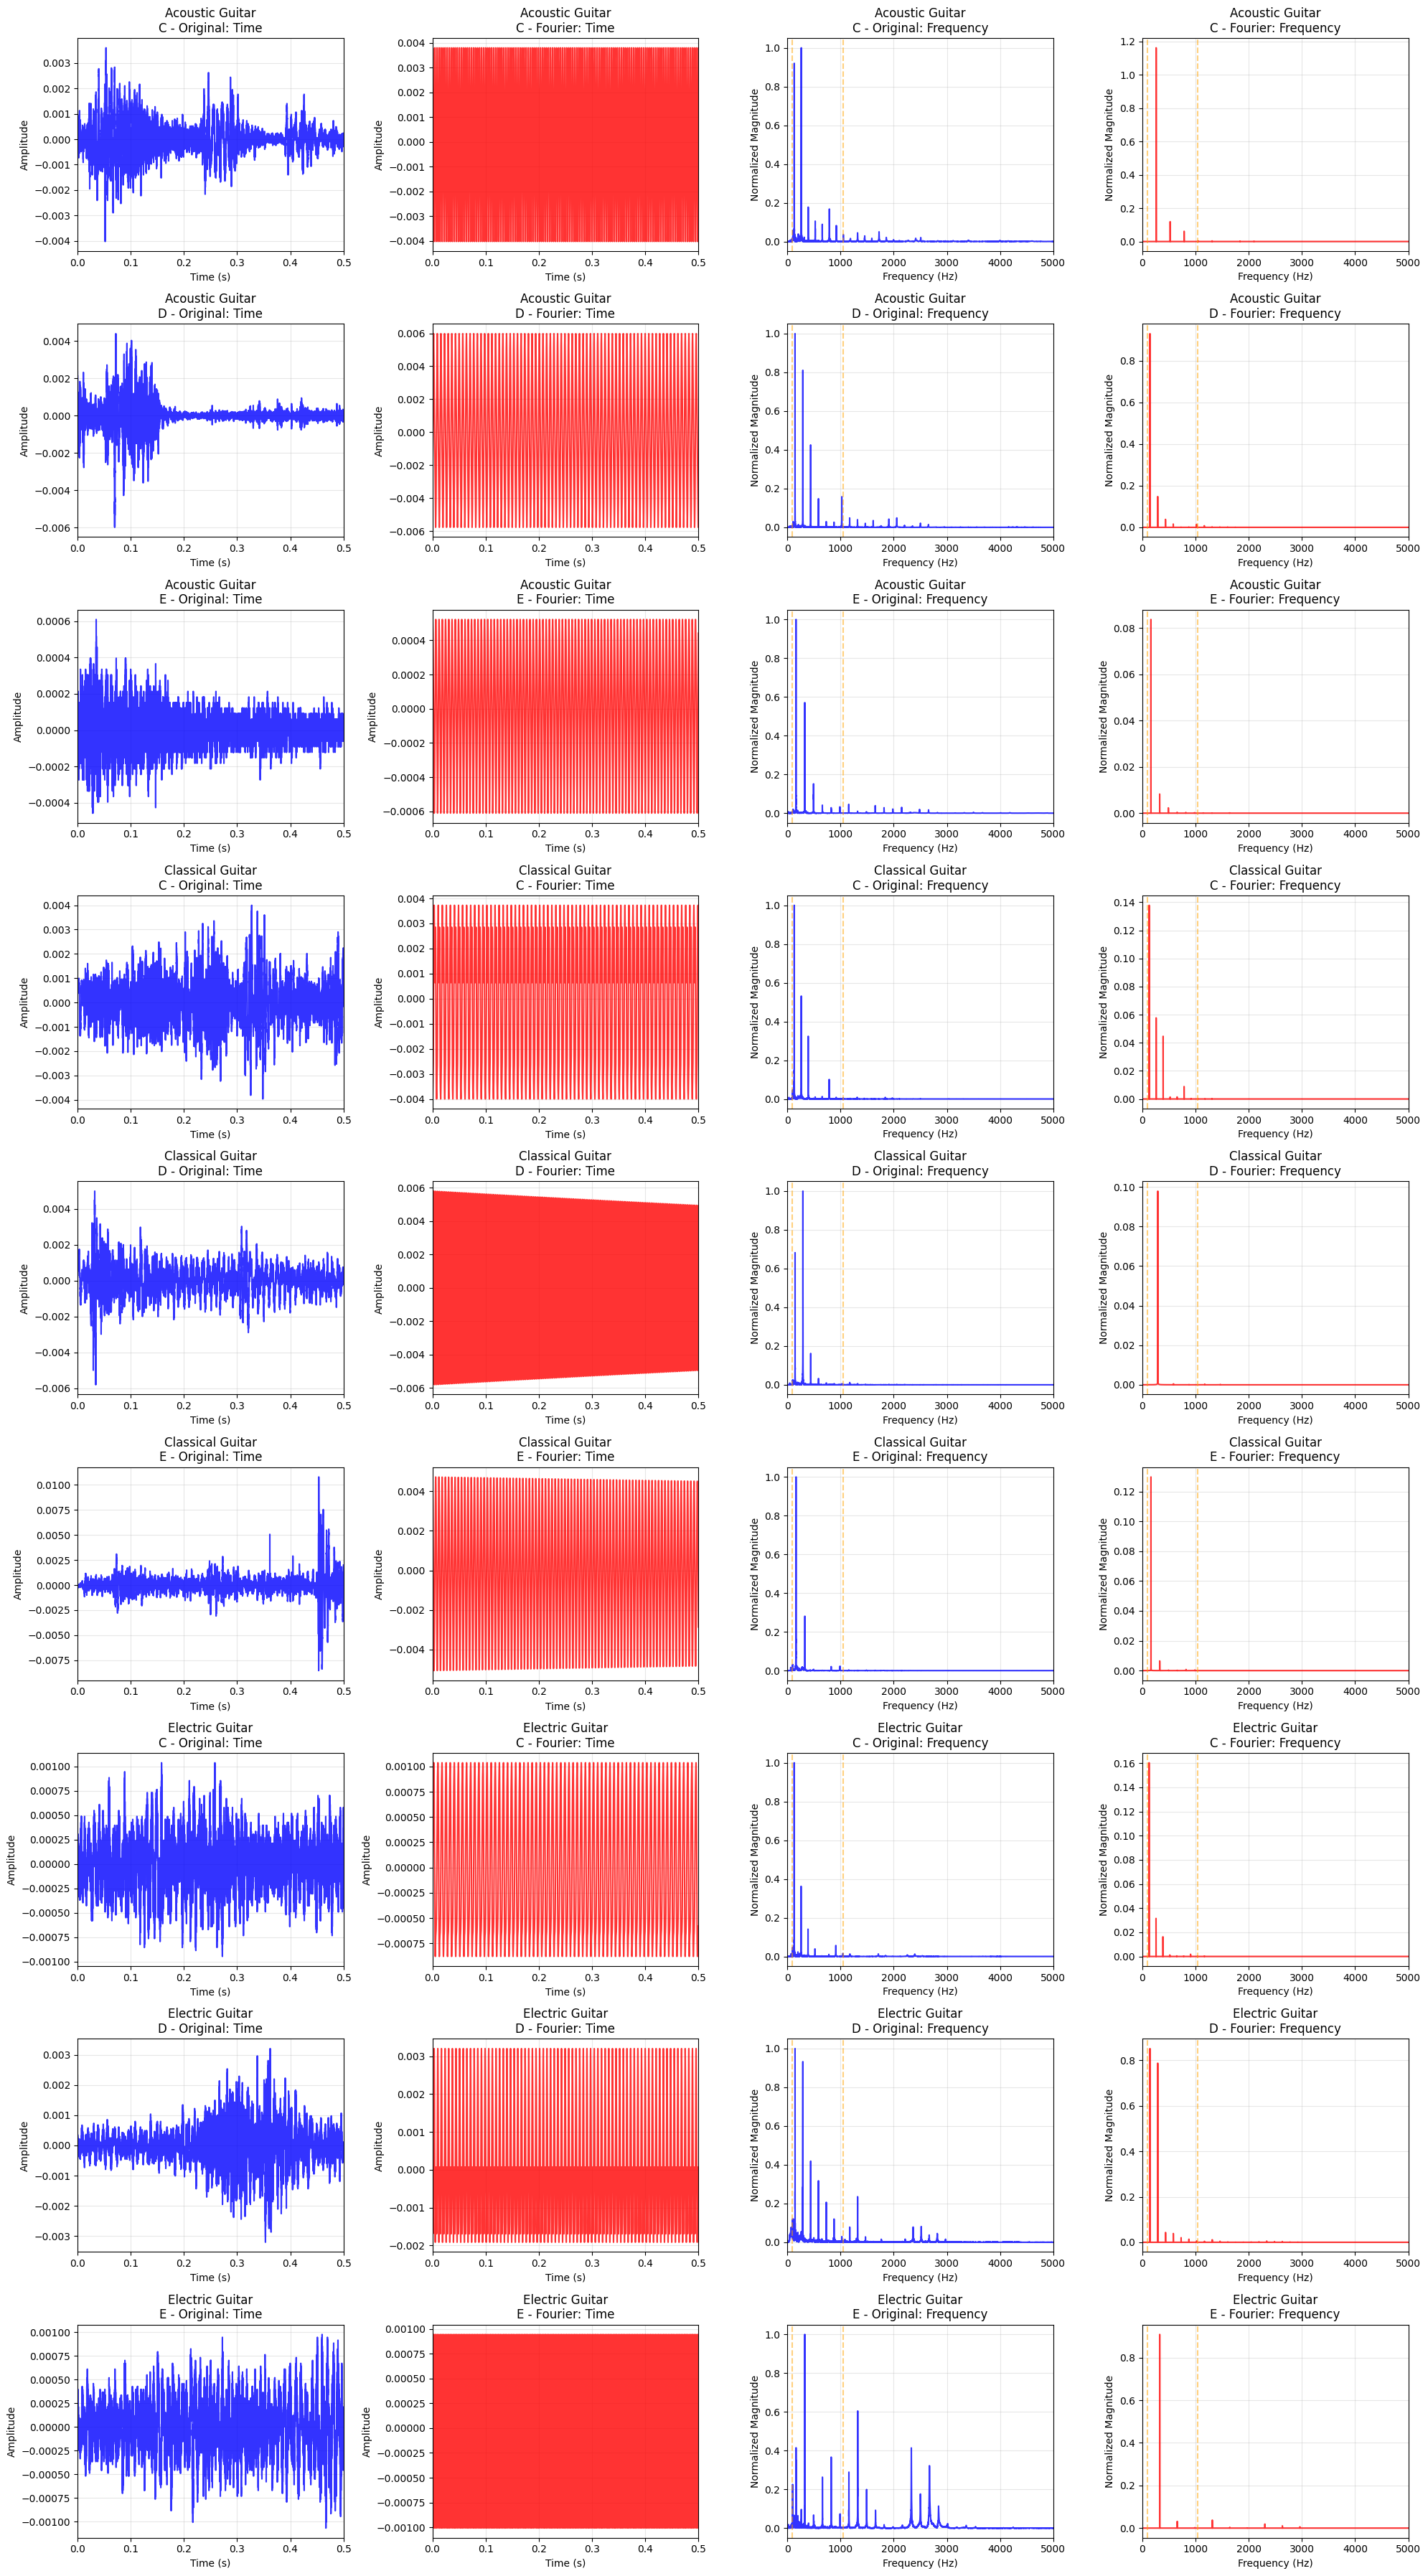

In [18]:
# Create comprehensive visualization for all instruments and notes
total_plots = len(INSTRUMENTS) * len(NOTES)
fig, axes = plt.subplots(total_plots, 4, figsize=(20, 4 * total_plots))

plot_idx = 0
for instrument in INSTRUMENTS:
    for note in NOTES:
        if results[instrument][note] is None:
            continue
            
        data = results[instrument][note]
        time = data['time']
        amp_orig = data['amplitude_original']
        # Use decay version if available, otherwise use steady-state
        amp_fourier = data.get('amplitude_fourier_decay', data['amplitude_fourier'])
        sample_rate = data['sample_rate']
        
        # Compute FFT
        fft_orig = rfft(amp_orig)
        fft_fourier = rfft(amp_fourier)
        freqs = rfftfreq(len(amp_orig), 1/sample_rate)
        mag_orig = np.abs(fft_orig)
        mag_fourier = np.abs(fft_fourier)
        
        # Normalize both to the same reference (original's peak) for fair comparison
        max_mag_orig = np.max(mag_orig) if np.max(mag_orig) > 0 else 1.0
        mag_orig_norm = mag_orig / max_mag_orig
        mag_fourier_norm = mag_fourier / max_mag_orig  # Use same normalization factor
        
        # Time window
        t_window = min(0.5, time[-1])
        t_mask = time <= t_window
        freq_mask = freqs <= 5000
        
        # Plot 1: Original - Time
        ax = axes[plot_idx, 0]
        ax.plot(time[t_mask], amp_orig[t_mask], 'b-', linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'{instrument.title()}\n{note} - Original: Time')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, t_window])
        
        # Plot 2: Fourier - Time
        ax = axes[plot_idx, 1]
        ax.plot(time[t_mask], amp_fourier[t_mask], 'r-', linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'{instrument.title()}\n{note} - Fourier: Time')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, t_window])
        
        # Plot 3: Original - Frequency
        ax = axes[plot_idx, 2]
        ax.plot(freqs[freq_mask], mag_orig_norm[freq_mask], 'b-', linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Normalized Magnitude')
        ax.set_title(f'{instrument.title()}\n{note} - Original: Frequency')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 5000])
        ax.axvline(98, color='orange', linestyle='--', alpha=0.5)
        ax.axvline(1047, color='orange', linestyle='--', alpha=0.5)
        
        # Plot 4: Fourier - Frequency
        ax = axes[plot_idx, 3]
        ax.plot(freqs[freq_mask], mag_fourier_norm[freq_mask], 'r-', linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Normalized Magnitude')
        ax.set_title(f'{instrument.title()}\n{note} - Fourier: Frequency')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 5000])
        ax.axvline(98, color='orange', linestyle='--', alpha=0.5)
        ax.axvline(1047, color='orange', linestyle='--', alpha=0.5)
        
        plot_idx += 1

plt.tight_layout()
plt.show()


## Overlay Comparisons


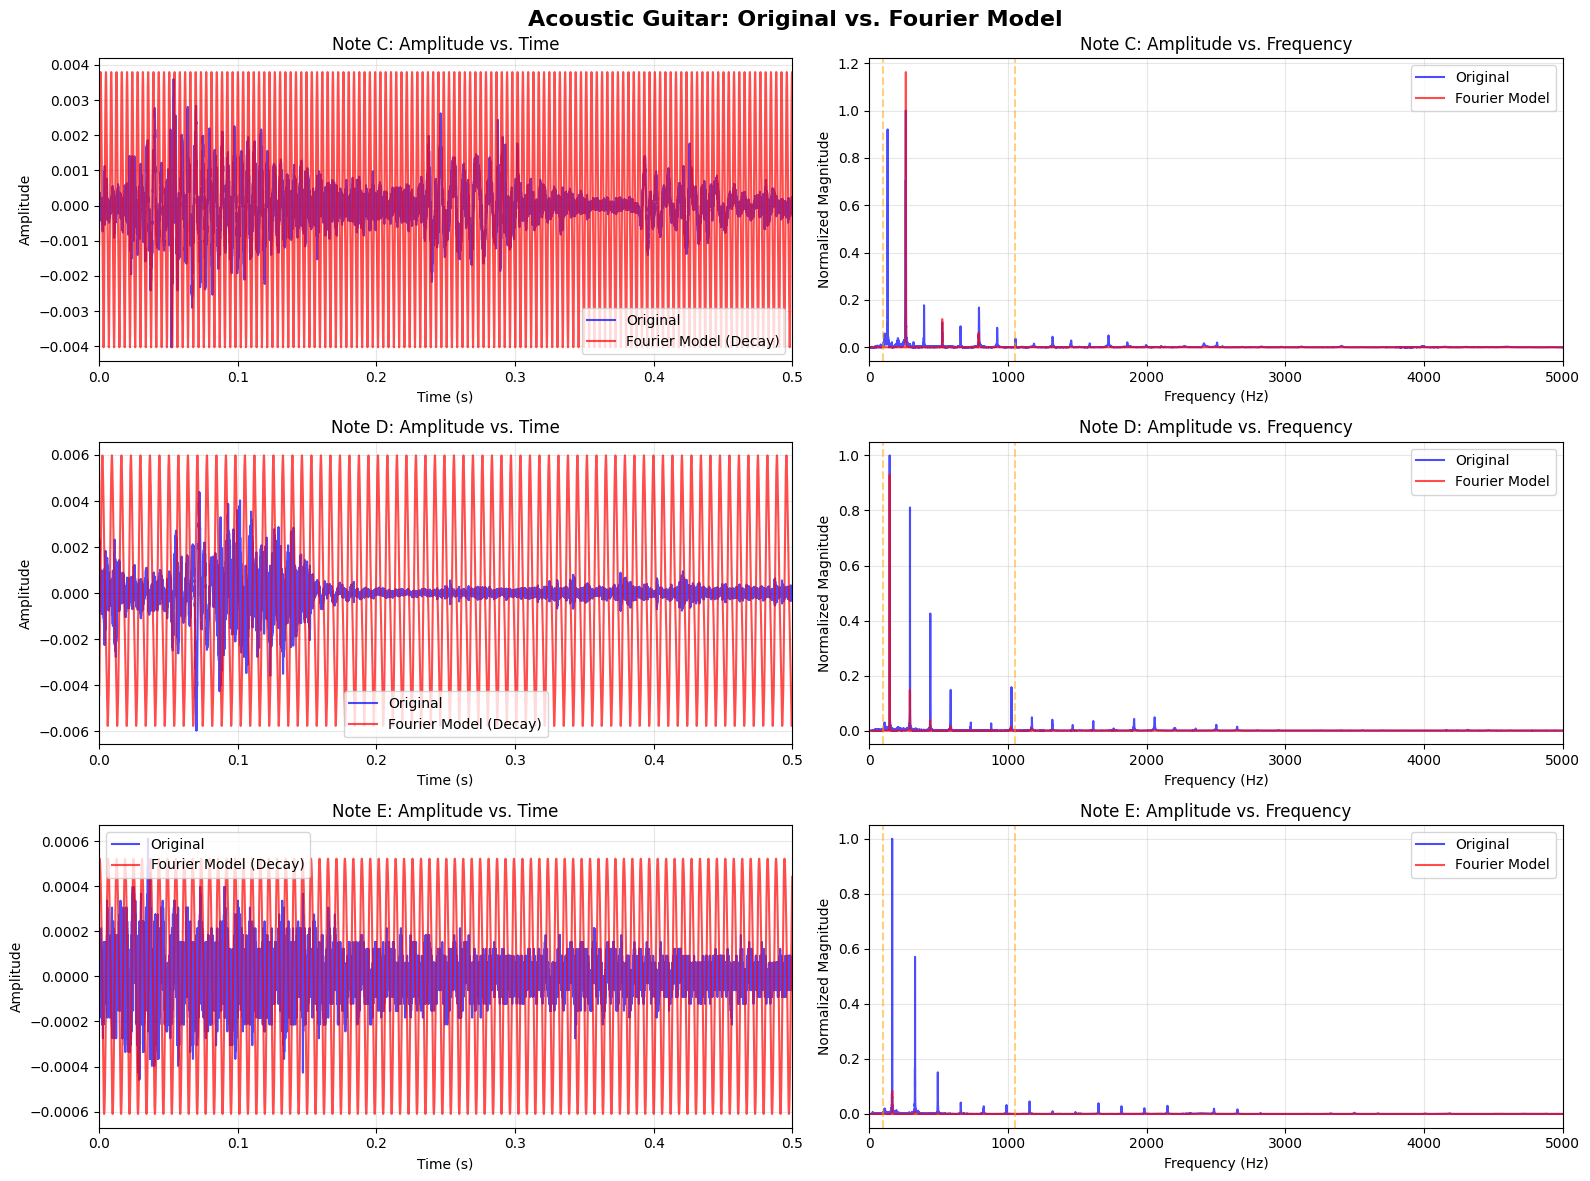

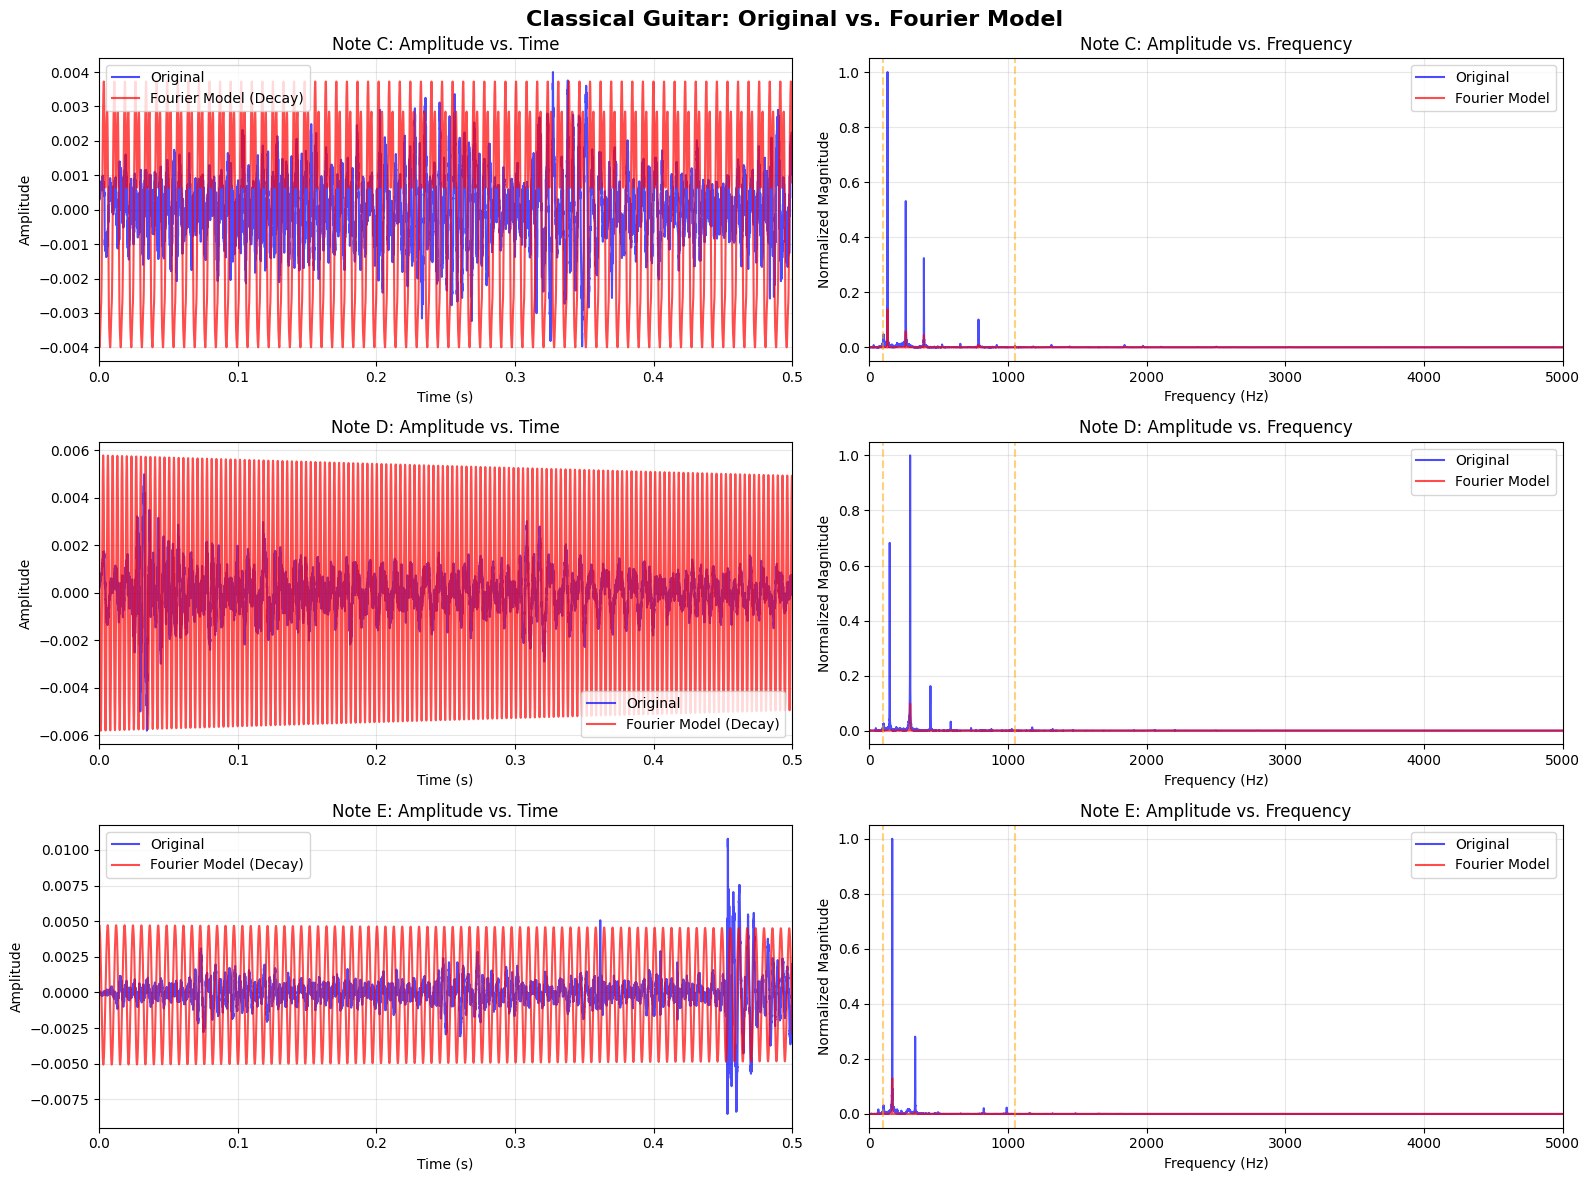

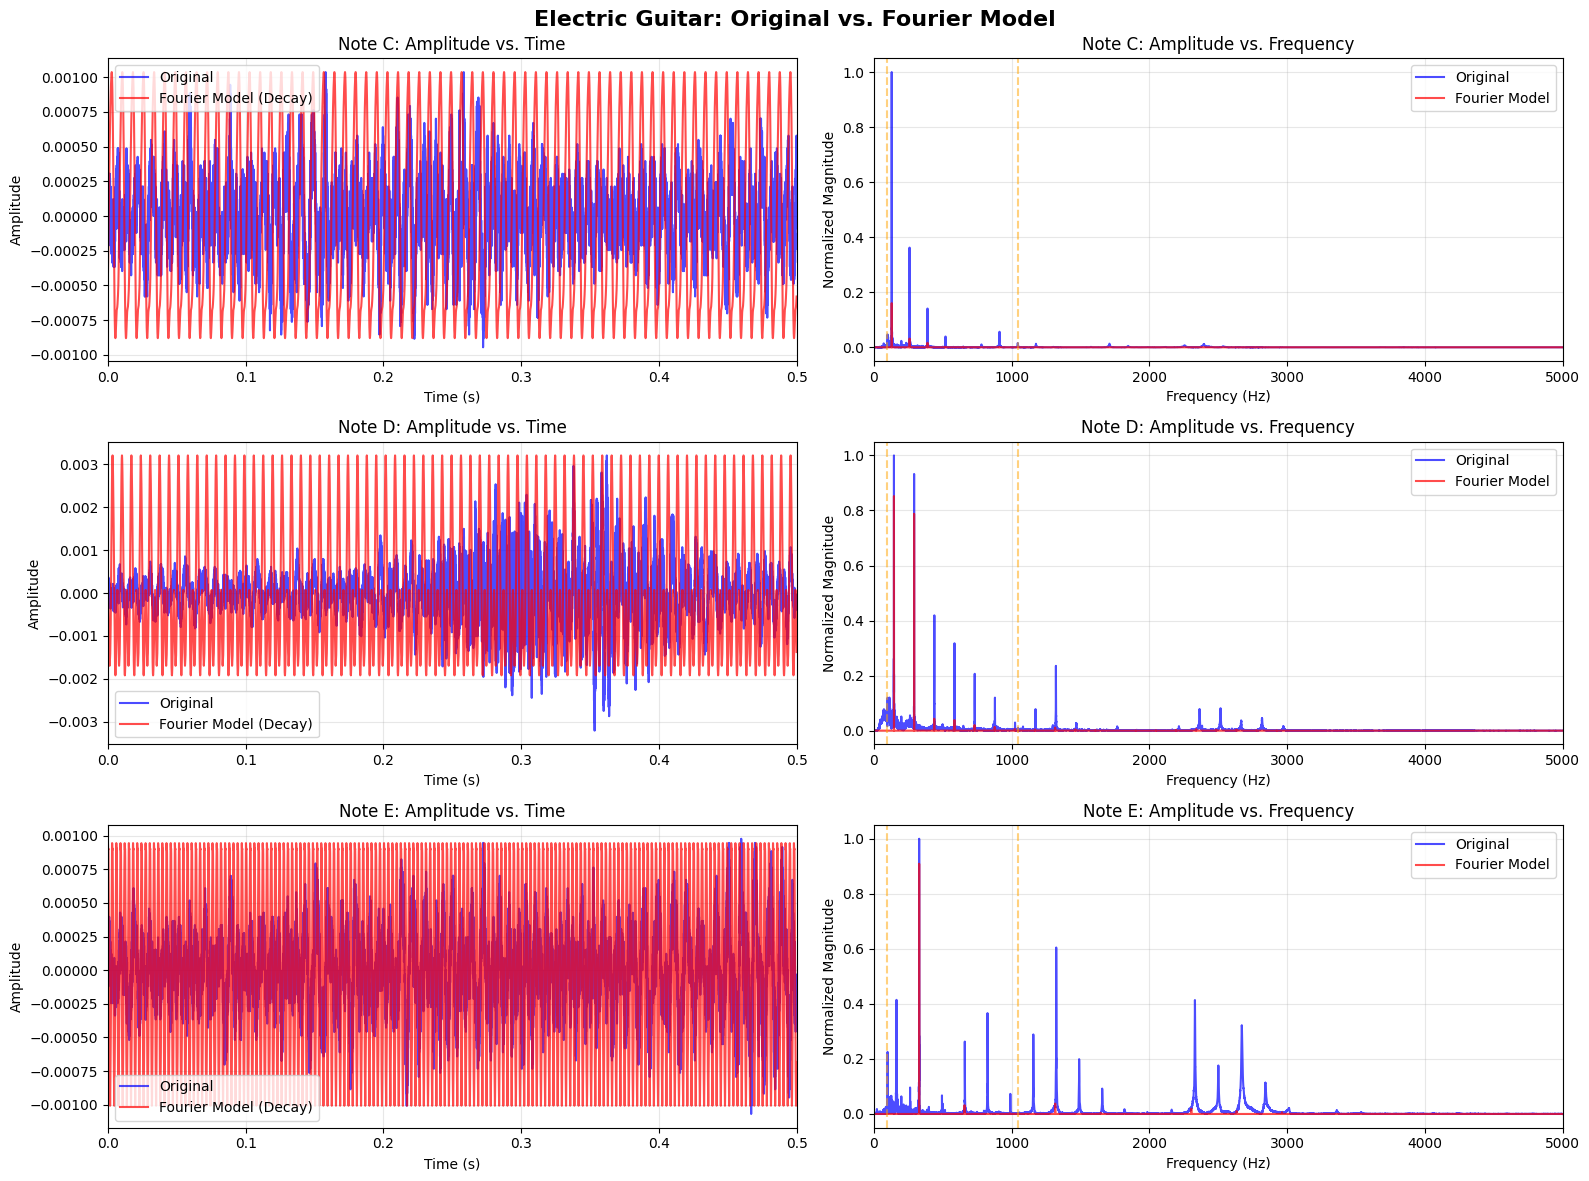

In [19]:
# Create overlay plots for each instrument/note combination
for instrument in INSTRUMENTS:
    fig, axes = plt.subplots(len(NOTES), 2, figsize=(16, 4 * len(NOTES)))
    fig.suptitle(f'{instrument.title()}: Original vs. Fourier Model', fontsize=16, fontweight='bold')
    
    for note_idx, note in enumerate(NOTES):
        if results[instrument][note] is None:
            continue
            
        data = results[instrument][note]
        time = data['time']
        amp_orig = data['amplitude_original']
        # Use decay version if available, otherwise use steady-state
        amp_fourier = data.get('amplitude_fourier_decay', data['amplitude_fourier'])
        amp_fourier_manual = data.get('amplitude_fourier_manual_decay')
        sample_rate = data['sample_rate']
        
        # Compute FFT
        fft_orig = rfft(amp_orig)
        fft_fourier = rfft(amp_fourier)
        freqs = rfftfreq(len(amp_orig), 1/sample_rate)
        mag_orig = np.abs(fft_orig)
        mag_fourier = np.abs(fft_fourier)
        
        # Normalize both to the same reference (original's peak) for fair comparison
        max_mag_orig = np.max(mag_orig) if np.max(mag_orig) > 0 else 1.0
        mag_orig_norm = mag_orig / max_mag_orig
        mag_fourier_norm = mag_fourier / max_mag_orig  # Use same normalization factor
        
        t_window = min(0.5, time[-1])
        t_mask = time <= t_window
        freq_mask = freqs <= 5000
        
        # Time domain overlay
        ax = axes[note_idx, 0]
        ax.plot(time[t_mask], amp_orig[t_mask], 'b-', linewidth=1.5, label='Original', alpha=0.7)
        ax.plot(time[t_mask], amp_fourier[t_mask], 'r-', linewidth=1.5, label='Fourier Model (Decay)', alpha=0.7)
        if SHOW_MANUAL_DECAY and amp_fourier_manual is not None:
            ax.plot(time[t_mask], amp_fourier_manual[t_mask], 'orange', linewidth=1.5, 
                   label=f'Fourier Model (Manual τ={MANUAL_DECAY_TAU:.2f}s)', alpha=0.7, linestyle='--')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Note {note}: Amplitude vs. Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, t_window])
        
        # Frequency domain overlay
        ax = axes[note_idx, 1]
        ax.plot(freqs[freq_mask], mag_orig_norm[freq_mask], 'b-', linewidth=1.5, label='Original', alpha=0.7)
        ax.plot(freqs[freq_mask], mag_fourier_norm[freq_mask], 'r-', linewidth=1.5, label='Fourier Model', alpha=0.7)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Normalized Magnitude')
        ax.set_title(f'Note {note}: Amplitude vs. Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 5000])
        ax.axvline(98, color='orange', linestyle='--', alpha=0.5, label='Sasando range')
        ax.axvline(1047, color='orange', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


In [20]:
# Compute distribution comparison metrics
def compute_distribution_metrics(signal1, signal2):
    """
    Compute various metrics to compare two signal distributions.
    
    Returns:
    - correlation: Pearson correlation coefficient
    - mse: Mean Squared Error
    - rmse: Root Mean Squared Error
    - mae: Mean Absolute Error
    - normalized_mse: MSE normalized by signal variance
    """
    # Ensure same length
    min_len = min(len(signal1), len(signal2))
    s1 = signal1[:min_len]
    s2 = signal2[:min_len]
    
    # Normalize for comparison
    s1_norm = (s1 - np.mean(s1)) / (np.std(s1) + 1e-10)
    s2_norm = (s2 - np.mean(s2)) / (np.std(s2) + 1e-10)
    
    # Correlation
    if len(s1) > 1:
        correlation = np.corrcoef(s1, s2)[0, 1]
    else:
        correlation = 0.0
    
    # MSE and RMSE
    mse = np.mean((s1 - s2)**2)
    rmse = np.sqrt(mse)
    
    # MAE
    mae = np.mean(np.abs(s1 - s2))
    
    # Normalized MSE (by variance of original)
    var_orig = np.var(s1)
    normalized_mse = mse / (var_orig + 1e-10)
    
    return {
        'correlation': correlation,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'normalized_mse': normalized_mse
    }

# Print summary table
print("\n" + "="*150)
print("SUMMARY: Fourier Model Matching Results")
print("="*150)
print(f"{'Instrument':<20} {'Note':<8} {'Fundamental (Hz)':<18} {'Max Ratio':<12} {'RMS Ratio':<12} {'Decay τ (s)':<15}")
print("-"*150)

for instrument in INSTRUMENTS:
    for note in NOTES:
        if results[instrument][note] is None:
            continue
            
        data = results[instrument][note]
        f0 = data['f0']
        amp_orig = data['amplitude_original']
        # Use decay version for comparison
        amp_fourier = data.get('amplitude_fourier_decay', data['amplitude_fourier'])
        tau = data['decay_tau']
        tau_used = data.get('decay_tau_used', tau)
        
        max_orig = np.max(np.abs(amp_orig))
        max_fourier = np.max(np.abs(amp_fourier))
        rms_orig = np.sqrt(np.mean(amp_orig**2))
        rms_fourier = np.sqrt(np.mean(amp_fourier**2))
        
        max_ratio = max_fourier / max_orig if max_orig > 0 else 0
        rms_ratio = rms_fourier / rms_orig if rms_orig > 0 else 0
        
        tau_str = f"{tau:.3f}" if tau < np.inf else "∞"
        tau_used_str = f"{tau_used:.3f}" if tau_used < np.inf else "∞"
        
        if APPLY_DECAY:
            print(f"{instrument:<20} {note:<8} {f0:<18.2f} {max_ratio:<12.2f} {rms_ratio:<12.2f} {tau_used_str:<15}")
        else:
            print(f"{instrument:<20} {note:<8} {f0:<18.2f} {max_ratio:<12.2f} {rms_ratio:<12.2f} {'N/A':<15}")

print("="*150)

# Distribution comparison metrics
print("\n" + "="*150)
print("DISTRIBUTION COMPARISON METRICS")
print("="*150)
print("\nAmplitude vs. Time Distribution Comparison:")
print(f"{'Instrument':<20} {'Note':<8} {'Correlation':<12} {'RMSE':<12} {'MAE':<12} {'Norm. MSE':<12}")
print("-"*150)

for instrument in INSTRUMENTS:
    for note in NOTES:
        if results[instrument][note] is None:
            continue
            
        data = results[instrument][note]
        amp_orig = data['amplitude_original']
        amp_fourier = data.get('amplitude_fourier_decay', data['amplitude_fourier'])
        sample_rate = data['sample_rate']
        
        # Time domain metrics
        time_metrics = compute_distribution_metrics(amp_orig, amp_fourier)
        
        print(f"{instrument:<20} {note:<8} {time_metrics['correlation']:<12.4f} "
              f"{time_metrics['rmse']:<12.6f} {time_metrics['mae']:<12.6f} "
              f"{time_metrics['normalized_mse']:<12.6f}")

print("\nAmplitude vs. Frequency Distribution Comparison:")
print(f"{'Instrument':<20} {'Note':<8} {'Correlation':<12} {'RMSE':<12} {'MAE':<12} {'Norm. MSE':<12}")
print("-"*150)

for instrument in INSTRUMENTS:
    for note in NOTES:
        if results[instrument][note] is None:
            continue
            
        data = results[instrument][note]
        amp_orig = data['amplitude_original']
        amp_fourier = data.get('amplitude_fourier_decay', data['amplitude_fourier'])
        sample_rate = data['sample_rate']
        
        # Frequency domain metrics
        fft_orig = rfft(amp_orig)
        fft_fourier = rfft(amp_fourier)
        mag_orig = np.abs(fft_orig)
        mag_fourier = np.abs(fft_fourier)
        
        # Normalize magnitudes for comparison
        mag_orig_norm = mag_orig / (np.max(mag_orig) + 1e-10)
        mag_fourier_norm = mag_fourier / (np.max(mag_fourier) + 1e-10)
        
        freq_metrics = compute_distribution_metrics(mag_orig_norm, mag_fourier_norm)
        
        print(f"{instrument:<20} {note:<8} {freq_metrics['correlation']:<12.4f} "
              f"{freq_metrics['rmse']:<12.6f} {freq_metrics['mae']:<12.6f} "
              f"{freq_metrics['normalized_mse']:<12.6f}")

print("="*150)
print("\nMetric Explanations:")
print("  Correlation: Pearson correlation coefficient (1.0 = perfect match, 0.0 = no correlation)")
print("  RMSE: Root Mean Squared Error (lower is better, 0 = perfect match)")
print("  MAE: Mean Absolute Error (lower is better, 0 = perfect match)")
print("  Norm. MSE: Normalized Mean Squared Error (lower is better, 0 = perfect match)")
print("\nNote: Max Ratio and RMS Ratio show how well the Fourier model matches the original.")
print("  Ratio ≈ 1.0 means good match")
print("  Ratio < 1.0 means model is quieter")
print("  Ratio > 1.0 means model is louder")
if APPLY_DECAY:
    print("\nDecay τ (tau): Time constant for exponential decay. Smaller values = faster decay.")
    if USE_EXTRACTED_DECAY:
        print("  Using decay parameters extracted from signal envelope.")
    else:
        print(f"  Using manually defined decay: τ={MANUAL_DECAY_TAU}s, A₀={MANUAL_DECAY_A0}")
    if USE_EXTRACTED_DECAY:
        print(f"  Manual decay version also generated: τ={MANUAL_DECAY_TAU}s for comparison.")
else:
    print("\nDecay: Not applied (steady-state model)")



SUMMARY: Fourier Model Matching Results
Instrument           Note     Fundamental (Hz)   Max Ratio    RMS Ratio    Decay τ (s)    
------------------------------------------------------------------------------------------------------------------------------------------------------
acoustic guitar      C        262.63             0.04         0.34         ∞              
acoustic guitar      D        145.90             0.08         0.39         ∞              
acoustic guitar      E        163.96             0.01         0.04         ∞              
classical guitar     C        131.14             0.01         0.06         ∞              
classical guitar     D        293.85             0.01         0.04         3.110          
classical guitar     E        164.75             0.01         0.06         10.546         
electric guitar      C        129.89             0.01         0.08         ∞              
electric guitar      D        146.26             0.03         0.32         ∞    